# start

from mdl0331_6__xgb_5e5;

mean encoding of langs

In [1]:
PRFX='mdl0402_1_2'

trntmstmp=1584412344
valtmstmp=1585761578

tm_trn_min,tm_trn_max=(1580947200, 1581551999)
tm_val_min,tm_val_max=(1581552000, 1582156799)

SEED=101

valsz = int(10)
trnsz = int(1e6)

train_total=int(1.5e8)
test_total=int(1.4e7)
print(f'train_total {train_total:,}, test_total {test_total:,}')


import datetime
def showtm(tm): return datetime.datetime.fromtimestamp(tm).strftime('%Y-%m-%d %H:%M:%S')
print([showtm(tm) for tm in (trntmstmp, valtmstmp)])
print([showtm(tm) for tm in (tm_trn_min,tm_trn_max)])
print([showtm(tm) for tm in (tm_val_min,tm_val_max)])

train_total 150,000,000, test_total 14,000,000
['2020-03-17 02:32:24', '2020-04-01 17:19:38']
['2020-02-06 00:00:00', '2020-02-12 23:59:59']
['2020-02-13 00:00:00', '2020-02-19 23:59:59']


# setup

In [2]:
from tqdm import tqdm
import time
from pathlib import Path
from collections import Counter
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, precision_recall_curve
import pickle
import xgboost as xgb
import lightgbm as lgb
import category_encoders as ce

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)


import datetime
def dtnow(): return datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')

def iou(s1,s2):
    return len(s1&s2) / len(s1|s2)

HOME='/data/git/recsys20'
p_in=f'{HOME}/input'
p_out=f'{HOME}/output/{PRFX}'
Path(p_out).mkdir(exist_ok=True, parents=True)

from sklearn.metrics import precision_recall_curve, auc, log_loss

def compute_prauc(pred, gt):
    prec, recall, thresh = precision_recall_curve(gt, pred)
    prauc = auc(recall, prec)
    return prauc

def calculate_ctr(gt):
    positive = len([x for x in gt if x == 1])
    ctr = positive/float(len(gt))
    return ctr

def compute_rce(pred, gt):
    cross_entropy = log_loss(gt, pred)
    data_ctr = calculate_ctr(gt)
    strawman_cross_entropy = log_loss(gt, [data_ctr for _ in range(len(gt))])
    return (1.0 - cross_entropy/strawman_cross_entropy)*100.0

cols=['toks','hshtgs','twtid','media','links','domns','twttyp','lang','tm','u1id','u1_fllwer_cnt','u1_fllwing_cnt','u1_vrfed','u1_create_tm','u2id','u2_follower_cnt','u2_following_cnt','u2_vrfed','u2_create_tm','u1_fllw_u2','reply_tm','retwt_tm','retwt_cmmnt_tm','like_tm',]

cols_val = cols[:-4]
cols_tgt_tmstmp=[ 'retwt_tm', 'reply_tm', 'like_tm', 'retwt_cmmnt_tm',]
cols_tgt=[o.split('_tm')[0] for o in cols_tgt_tmstmp]
tgts             = ['Retweet','Reply','Like','RTwCmnt',]
assert cols_tgt == ['retwt',  'reply','like','retwt_cmmnt',]
tgt2col = dict(zip(tgts, cols_tgt))
print(tgt2col)
ntgts=len(tgts)

{'Retweet': 'retwt', 'Reply': 'reply', 'Like': 'like', 'RTwCmnt': 'retwt_cmmnt'}


# prep

In [3]:
%%time
dftrn = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',header=None,names=cols,
                     skiprows=valsz,nrows=trnsz)

CPU times: user 6.95 s, sys: 768 ms, total: 7.72 s
Wall time: 7.72 s


In [4]:
lst_hshtgs = dftrn.hshtgs[dftrn.hshtgs.notna()].apply(lambda x: x.split('\t'))
hstgs_all = [j for i in lst_hshtgs for j in i]
hshtg2cnt = Counter(hstgs_all)
ttl=len(dftrn)
hshtg2frq = {k:v/ttl for k,v in hshtg2cnt.items()}
hshtg2cnt.most_common(10)

[('5671B8B6E92C2A316C05A7CD2F17366C', 2689),
 ('B6024D6F02AFAF9BC8ED941F72C228F1', 2551),
 ('18F6AC96A6EA62716A47DE9FE6241534', 1490),
 ('31C316EB7BB8CD1778CB83B8AA2603D9', 1132),
 ('EA152CAF6EE7894E914C522BD1B5E702', 950),
 ('746E379897167C3B81A180BF8BAADD8D', 947),
 ('E78674D323461112D0DCF8010AF5AED3', 918),
 ('F3A652C947EB7F5D093A48E95EFC62F5', 846),
 ('8420CD4576AC5373530F43B36DCA52AC', 815),
 ('F564E2BDCB9A0ABADDD4A9EE053DFCD2', 736)]

In [5]:
lst_links = dftrn.links[dftrn.links.notna()].apply(lambda x: x.split('\t'))
hstgs_all = [j for i in lst_links for j in i]
link2cnt = Counter(hstgs_all)
ttl=len(dftrn)
link2frq = {k:v/ttl for k,v in link2cnt.items()}
link2cnt.most_common(10)

[('E522B6C629B01DA6B29DE65BF5DFA55B', 240),
 ('140BCA0056E50C79778369C95D6DDC63', 103),
 ('DEA673FD63DDDC8A3606106D5CA235B0', 98),
 ('270B33AB02B6FB3F60B748CF1CB9AB75', 75),
 ('180511B4A939ADAD39FDB6604C1A9AC5', 72),
 ('4C4CB3FCFEB284BAB26F4AB727B843F9', 71),
 ('843401FA907A6D69D70FDAEDCFD5362E', 69),
 ('6DDBD9DAAA2AE38B8EBB54BA8E7098DD', 68),
 ('A00951C40B7EC9B21DFA4168B9287D39', 60),
 ('60DE00805B565526B32FF78F6EF0B9F7', 59)]

In [6]:
lst_domns = dftrn.domns[dftrn.domns.notna()].apply(lambda x: x.split('\t'))
domns_all = [j for i in lst_domns for j in i]
domn2cnt = Counter(domns_all)
ttl=len(dftrn)
domn2frq = {k:v/ttl for k,v in domn2cnt.items()}
domn2cnt.most_common(10)

[('3896E26D12C903F0A00B6B1BE9A9BEA3', 13735),
 ('E91CDEC8DC7ABF30592FA024616FF970', 8602),
 ('FECA6F2E8244F2294BD2CE957C0602A9', 6375),
 ('FCA72262B99BB78F010B25C882A0C93C', 3579),
 ('A32007FFB62B2DFC4E449BD37F985C53', 2074),
 ('9E34EBC679CA0BC677D198BEE3E37113', 1887),
 ('A898ECD422D0575A276A0D74CD01C867', 1887),
 ('BBA1D3359A23689C6783652EA73B12BA', 1419),
 ('979ECC05068307E0490EA1B9B9B44411', 1157),
 ('892B6E0BC037800B59112CFCB95E3301', 1133)]

In [7]:
twttyps=['TopLevel','Retweet','Quote']

lang2freq=dict(dftrn.lang.value_counts()/len(dftrn))
langs2feat=[k for k,v in lang2freq.items() if v>=0.01]
len(langs2feat)

11

In [8]:
def prp_tm(df, col):
    dt=pd.to_datetime(df[col], unit='s')
    df[col+'_dayofweek']=dt.dt.dayofweek
    df[col+'_hour']=dt.dt.hour

def prpdf(df,istrn=True,debug=False):
    tags = ['hshtgs','media','links','domns',]
    for tag in tags:
        df[f'has_{tag}']=df[tag].notna()
        df[tag]=df[tag].fillna('').apply(lambda x: x.split('\t') if len(x) else [])
        df[f'n_{tag}']=df[tag].apply(len)
    
    df['sum_frq_hshtg']=df['hshtgs'].apply(lambda x: sum([hshtg2frq.get(o,0) for o in x]))
    df['max_frq_hshtg']=df['hshtgs'].apply(lambda x: max([hshtg2frq.get(o,0) for o in x]) if len(x) else 0)
    df['sum_frq_domn']=df['domns'].apply(lambda x: sum([domn2frq.get(o,0) for o in x]))
    df['max_frq_domn']=df['domns'].apply(lambda x: max([domn2frq.get(o,0) for o in x]) if len(x) else 0)
        
    for m in ['Photo', 'Video', 'GIF']:
        df[f'n_media_{m}'] = df['media'].apply(lambda x: x.count(m))
    
    df['toks']=df.toks.apply(lambda x: x.split('\t'))
    df['len_toks']=df.toks.apply(len)
    
    prp_tm(df, 'tm')
    
    df['tmdlta_u2u1']  = df.u2_create_tm - df.u1_create_tm
    df['tmdlta_twtu1'] = df.tm - df.u1_create_tm
    df['tmdlta_twtu2'] = df.tm - df.u2_create_tm
    if istrn:
        df['tmleft_twt']   = tm_trn_max-df.tm
        df['tmleft_u1']    = tm_trn_max-df.u1_create_tm
        df['tmleft_u2']    = tm_trn_max-df.u2_create_tm
    else:
        df['tmleft_twt']   = tm_val_max-df.tm
        df['tmleft_u1']    = tm_val_max-df.u1_create_tm
        df['tmleft_u2']    = tm_val_max-df.u2_create_tm

    for typ in twttyps:
        df[f'twttyp_{typ}']=(df.twttyp==typ).astype('int8')

    for lang in langs2feat:
        df[f'lang_{lang}']=(df.lang==lang).astype('int8')
    
    df['u1u2']=df.u1id+'_'+df.u2id
    ce_features = ['lang', 'u1id', 'u2id', 'u1u2', 'twtid']
    cnt_encd = ce.CountEncoder()
    cnt_encded = cnt_encd.fit_transform(df[ce_features])
    cnt_encded = cnt_encded.astype(int)
    cnt_encded = cnt_encded/len(df)
    cnt_encded.columns = [f'{col}_freq' for col in ce_features]
    df = pd.concat([df,cnt_encded],1)

    if istrn: 
        df[cols_tgt]=df[cols_tgt_tmstmp].notna()
        if not debug: df.drop(inplace=True, columns=['toks','hshtgs','media','links','domns','twttyp', 
                                       'tm','u1_create_tm','u2_create_tm','u1u2','u1id','u2id', 'twtid', ]+cols_tgt_tmstmp, )
    else:
        if not debug: df.drop(inplace=True, columns=['toks','hshtgs','media','links','domns','twttyp', 
                                       'tm','u1_create_tm','u2_create_tm','u1u2','u1id', ])        
    return df    

In [9]:
%%time
dftrn = prpdf(dftrn)

/data/anaconda3/envs/rcss20/lib/python3.7/site-packages/category_encoders/count.py:255: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  X.loc[:, self.cols] = X.fillna(value=pd.np.nan)


CPU times: user 25.4 s, sys: 3.98 s, total: 29.4 s
Wall time: 29.4 s


In [10]:
# verify preprocess
# dftrn = prpdf(dftrn, debug=True)
# display(dftrn[['media','n_media_Photo', 'n_media_Video', 'n_media_GIF',]].sample(5))
# display(dftrn[['hshtgs','has_hshtgs', 'n_hshtgs', 'sum_frq_hshtg', 'max_frq_hshtg']].sample(5))
# display(dftrn[['domns','has_domns', 'n_domns', 'sum_frq_domn', 'max_frq_domn']].sample(5))

In [11]:
%%time
dfval = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',header=None,names=cols,nrows=valsz)

CPU times: user 7.11 ms, sys: 0 ns, total: 7.11 ms
Wall time: 6.49 ms


In [12]:
%%time
dfval = prpdf(dfval)

CPU times: user 80.7 ms, sys: 5.24 ms, total: 85.9 ms
Wall time: 76.1 ms


## mean encoding

In [13]:
msk_vl=np.random.rand(len(dftrn))<0.15
idxvl=np.where( msk_vl)[0]
idxtr=np.where(~msk_vl)[0]

In [14]:
dftr = dftrn.iloc[idxtr].copy()
dfvl = dftrn.iloc[idxvl].copy()

In [15]:
dftr.shape,dfvl.shape

((849983, 55), (150017, 55))

In [16]:
col2lang2mean={}
for col in cols_tgt:
    col2lang2mean[col]=dict(dftr.groupby('lang')[col].mean())    

In [17]:
pickle.dump(col2lang2mean, open(f'{p_out}/col2lang2mean.p', 'wb'))

In [18]:
dftr.head()

,lang,u1_fllwer_cnt,u1_fllwing_cnt,u1_vrfed,u2_follower_cnt,u2_following_cnt,u2_vrfed,u1_fllw_u2,has_hshtgs,n_hshtgs,has_media,n_media,has_links,n_links,has_domns,n_domns,sum_frq_hshtg,max_frq_hshtg,sum_frq_domn,max_frq_domn,n_media_Photo,n_media_Video,n_media_GIF,len_toks,tm_dayofweek,tm_hour,tmdlta_u2u1,tmdlta_twtu1,tmdlta_twtu2,tmleft_twt,tmleft_u1,tmleft_u2,twttyp_TopLevel,twttyp_Retweet,twttyp_Quote,lang_D3164C7FBCF2565DDF915B1B3AEFB1DC,lang_22C448FF81263D4BAF2A176145EE9EAD,lang_06D61DCBBE938971E1EA0C38BD9B5446,lang_ECED8A16BE2A5E8871FD55F4842F16B1,lang_B9175601E87101A984A50F8A62A1C374,lang_4DC22C3F31C5C43721E6B5815A595ED6,lang_167115458A0DBDFF7E9C0C53A83BAC9B,lang_125C57F4FA6D4E110983FB11B52EFD4E,lang_022EC308651FACB02794A8147AEE1B78,lang_FA3F382BC409C271E3D6EAF8BE4648DD,lang_9BF3403E0EB7EA8A256DA9019C0B0716,lang_freq,u1id_freq,u2id_freq,u1u2_freq,twtid_freq,retwt,reply,like,retwt_cmmnt
0,D3164C7FBCF2565DDF915B1B3AEFB1DC,369,369,False,225,185,False,True,False,0,True,1,False,0,False,0,0.0,0.0,0.0,0.0,0,1,0,30,0,17,128719427,169062641,40343214,195605,169258246,40538819,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0.410966,0.000001,0.000001,0.000001,0.000001,False,False,True,False
1,06D61DCBBE938971E1EA0C38BD9B5446,1757,4999,False,216,391,False,True,False,0,False,0,False,0,False,0,0.0,0.0,0.0,0.0,0,0,0,16,5,23,-2402543,19325288,21727831,345877,19671165,22073708,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0.089365,0.000001,0.000003,0.000001,0.000001,False,False,False,False
2,06D61DCBBE938971E1EA0C38BD9B5446,781,323,False,214,390,False,True,False,0,False,0,False,0,False,0,0.0,0.0,0.0,0.0,0,0,0,32,3,22,54115549,75664720,21549171,524537,76189257,22073708,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0.089365,0.000001,0.000003,0.000001,0.000001,False,False,False,False
3,06D61DCBBE938971E1EA0C38BD9B5446,128,493,False,218,394,False,True,False,0,False,0,False,0,False,0,0.0,0.0,0.0,0.0,0,0,0,49,0,6,17924683,39760804,21836121,237587,39998391,22073708,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0.089365,0.000001,0.000003,0.000001,0.000001,False,False,True,False
4,125C57F4FA6D4E110983FB11B52EFD4E,524,524,False,56,108,False,True,False,0,True,1,False,0,False,0,0.0,0.0,0.0,0.0,0,1,0,32,1,14,-8717522,9271806,17989328,120803,9392609,18110131,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0.024340,0.000001,0.000001,0.000001,0.000001,True,False,False,False


In [19]:
for col,lang2mean in col2lang2mean.items():
    dftr[f'mean_lang_{col}']  = dftr.lang.map(lang2mean)
    dfvl[f'mean_lang_{col}']  = dfvl.lang.map(lang2mean)
    dfval[f'mean_lang_{col}'] = dfval.lang.map(lang2mean)
dftr.drop(columns='lang',inplace=True)
dfvl.drop(columns='lang',inplace=True)
dfval.drop(columns='lang',inplace=True)

In [20]:
dftr.head()

,u1_fllwer_cnt,u1_fllwing_cnt,u1_vrfed,u2_follower_cnt,u2_following_cnt,u2_vrfed,u1_fllw_u2,has_hshtgs,n_hshtgs,has_media,n_media,has_links,n_links,has_domns,n_domns,sum_frq_hshtg,max_frq_hshtg,sum_frq_domn,max_frq_domn,n_media_Photo,n_media_Video,n_media_GIF,len_toks,tm_dayofweek,tm_hour,tmdlta_u2u1,tmdlta_twtu1,tmdlta_twtu2,tmleft_twt,tmleft_u1,tmleft_u2,twttyp_TopLevel,twttyp_Retweet,twttyp_Quote,lang_D3164C7FBCF2565DDF915B1B3AEFB1DC,lang_22C448FF81263D4BAF2A176145EE9EAD,lang_06D61DCBBE938971E1EA0C38BD9B5446,lang_ECED8A16BE2A5E8871FD55F4842F16B1,lang_B9175601E87101A984A50F8A62A1C374,lang_4DC22C3F31C5C43721E6B5815A595ED6,lang_167115458A0DBDFF7E9C0C53A83BAC9B,lang_125C57F4FA6D4E110983FB11B52EFD4E,lang_022EC308651FACB02794A8147AEE1B78,lang_FA3F382BC409C271E3D6EAF8BE4648DD,lang_9BF3403E0EB7EA8A256DA9019C0B0716,lang_freq,u1id_freq,u2id_freq,u1u2_freq,twtid_freq,retwt,reply,like,retwt_cmmnt,mean_lang_retwt,mean_lang_reply,mean_lang_like,mean_lang_retwt_cmmnt
0,369,369,False,225,185,False,True,False,0,True,1,False,0,False,0,0.0,0.0,0.0,0.0,0,1,0,30,0,17,128719427,169062641,40343214,195605,169258246,40538819,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0.410966,0.000001,0.000001,0.000001,0.000001,False,False,True,False,0.106309,0.024528,0.433892,0.008643
1,1757,4999,False,216,391,False,True,False,0,False,0,False,0,False,0,0.0,0.0,0.0,0.0,0,0,0,16,5,23,-2402543,19325288,21727831,345877,19671165,22073708,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0.089365,0.000001,0.000003,0.000001,0.000001,False,False,False,False,0.117974,0.028287,0.392760,0.008295
2,781,323,False,214,390,False,True,False,0,False,0,False,0,False,0,0.0,0.0,0.0,0.0,0,0,0,32,3,22,54115549,75664720,21549171,524537,76189257,22073708,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0.089365,0.000001,0.000003,0.000001,0.000001,False,False,False,False,0.117974,0.028287,0.392760,0.008295
3,128,493,False,218,394,False,True,False,0,False,0,False,0,False,0,0.0,0.0,0.0,0.0,0,0,0,49,0,6,17924683,39760804,21836121,237587,39998391,22073708,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0.089365,0.000001,0.000003,0.000001,0.000001,False,False,True,False,0.117974,0.028287,0.392760,0.008295
4,524,524,False,56,108,False,True,False,0,True,1,False,0,False,0,0.0,0.0,0.0,0.0,0,1,0,32,1,14,-8717522,9271806,17989328,120803,9392609,18110131,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0.024340,0.000001,0.000001,0.000001,0.000001,True,False,False,False,0.234812,0.019495,0.432177,0.007962


In [21]:
cols_feat=[o for o in dftr.columns if o not in cols_tgt]
cols_feat

['u1_fllwer_cnt',
 'u1_fllwing_cnt',
 'u1_vrfed',
 'u2_follower_cnt',
 'u2_following_cnt',
 'u2_vrfed',
 'u1_fllw_u2',
 'has_hshtgs',
 'n_hshtgs',
 'has_media',
 'n_media',
 'has_links',
 'n_links',
 'has_domns',
 'n_domns',
 'sum_frq_hshtg',
 'max_frq_hshtg',
 'sum_frq_domn',
 'max_frq_domn',
 'n_media_Photo',
 'n_media_Video',
 'n_media_GIF',
 'len_toks',
 'tm_dayofweek',
 'tm_hour',
 'tmdlta_u2u1',
 'tmdlta_twtu1',
 'tmdlta_twtu2',
 'tmleft_twt',
 'tmleft_u1',
 'tmleft_u2',
 'twttyp_TopLevel',
 'twttyp_Retweet',
 'twttyp_Quote',
 'lang_D3164C7FBCF2565DDF915B1B3AEFB1DC',
 'lang_22C448FF81263D4BAF2A176145EE9EAD',
 'lang_06D61DCBBE938971E1EA0C38BD9B5446',
 'lang_ECED8A16BE2A5E8871FD55F4842F16B1',
 'lang_B9175601E87101A984A50F8A62A1C374',
 'lang_4DC22C3F31C5C43721E6B5815A595ED6',
 'lang_167115458A0DBDFF7E9C0C53A83BAC9B',
 'lang_125C57F4FA6D4E110983FB11B52EFD4E',
 'lang_022EC308651FACB02794A8147AEE1B78',
 'lang_FA3F382BC409C271E3D6EAF8BE4648DD',
 'lang_9BF3403E0EB7EA8A256DA9019C0B0716',


# model

In [22]:
tgt2params = {k:{'objective': 'binary:logistic',
    'verbosity': 1,
    'eval_metric': [ 'aucpr','logloss',],
} for k in tgts}
tgt2res = {}


In [23]:
def train(params,dtr,dvl):
    print(params)
    evals_result = {}
    evallist = [(dtr, 'train'), (dvl, 'eval')]
    bst = xgb.train(params=params, dtrain=dtr, num_boost_round=10000, 
                    evals=evallist, evals_result=evals_result, 
                    verbose_eval=100,
                    early_stopping_rounds=1000)
    return bst,evals_result

def valid(bst,dtr,dvl):
    prdtr = bst.predict(dtr, ntree_limit=bst.best_ntree_limit)
    prdvl = bst.predict(dvl, ntree_limit=bst.best_ntree_limit)
    return prdtr,prdvl


def traintgt(tgt):
    params=tgt2params[tgt]
    tgtcol=tgt2col[tgt]
    
    ytr=dftr[tgtcol]
    yvl=dfvl[tgtcol]
    dtr = xgb.DMatrix(dftr[cols_feat], label=ytr, feature_names=cols_feat)
    dvl = xgb.DMatrix(dfvl[cols_feat], label=yvl, feature_names=cols_feat)
    bst,evals_result=train(params,dtr,dvl)
    prdtr,prdvl=valid(bst,dtr,dvl)
    return {
    'bst':bst,
    'evals_result':evals_result,
    'ytr':ytr,
    'yvl':yvl,
    'prdtr':prdtr,
    'prdvl':prdvl,
    }
    

In [24]:
for tgt in tgts:
    print(dtnow(), tgt, '*'*80)
    tmstart=time.time()
    tgt2res[tgt]=traintgt(tgt)
    print('Ran for',int((time.time()-tmstart)/60),'mins')

2020-04-02 21:04:28 Retweet ********************************************************************************
{'objective': 'binary:logistic', 'verbosity': 1, 'eval_metric': ['aucpr', 'logloss']}
[0]	train-aucpr:0.27152	train-logloss:0.53265	eval-aucpr:0.27335	eval-logloss:0.53227
Multiple eval metrics have been passed: 'eval-logloss' will be used for early stopping.

Will train until eval-logloss hasn't improved in 1000 rounds.
[100]	train-aucpr:0.39414	train-logloss:0.29190	eval-aucpr:0.35252	eval-logloss:0.30077
[200]	train-aucpr:0.43007	train-logloss:0.28342	eval-aucpr:0.35700	eval-logloss:0.29975
[300]	train-aucpr:0.46037	train-logloss:0.27611	eval-aucpr:0.35816	eval-logloss:0.29966
[400]	train-aucpr:0.48756	train-logloss:0.26955	eval-aucpr:0.35872	eval-logloss:0.29969
[500]	train-aucpr:0.51008	train-logloss:0.26430	eval-aucpr:0.35819	eval-logloss:0.30006
[600]	train-aucpr:0.53305	train-logloss:0.25870	eval-aucpr:0.35735	eval-logloss:0.30044
[700]	train-aucpr:0.55632	train-logloss:

# analyze

## tr vl

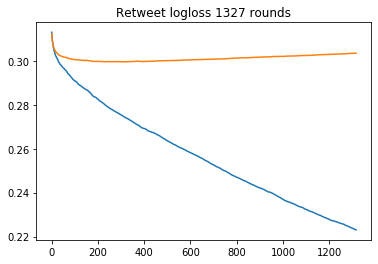

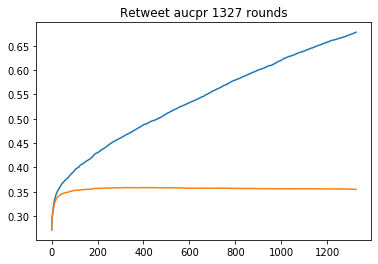

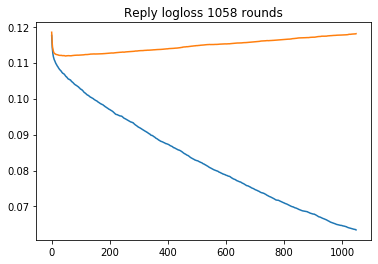

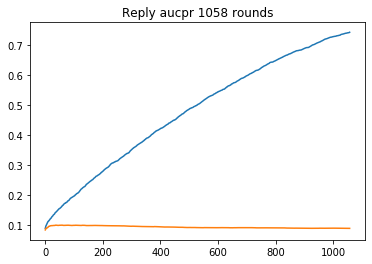

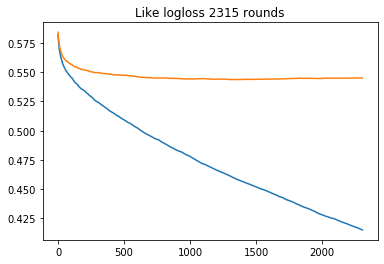

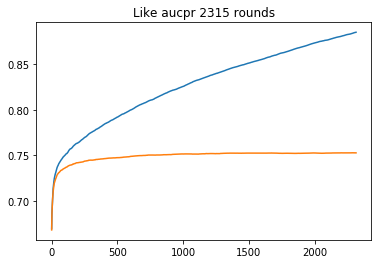

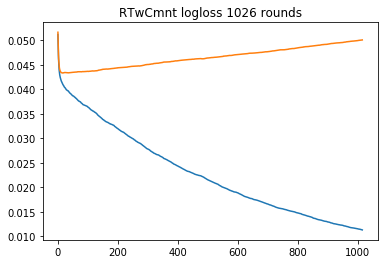

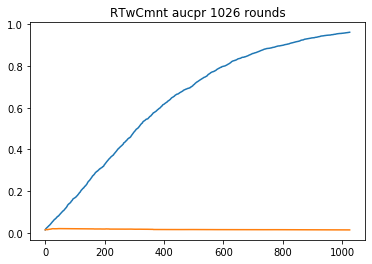

In [25]:
for tgt,res in tgt2res.items():
    evalres=res['evals_result']
    plt.plot(evalres['train']['logloss'][10:])
    plt.plot(evalres['eval']['logloss'][10:])
    plt.title(f"{tgt} logloss {len(evalres['train']['logloss'])} rounds")
    plt.show()
    plt.plot(evalres['train']['aucpr'])
    plt.plot(evalres['eval']['aucpr'])
    plt.title(f"{tgt} aucpr {len(evalres['train']['aucpr'])} rounds")
    plt.show()

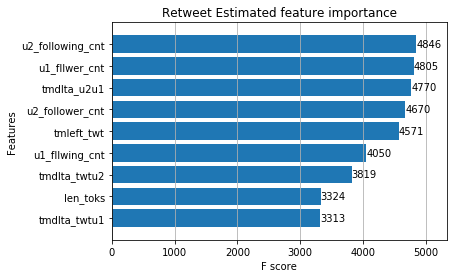

Retweet


,0,1
9,u2_following_cnt,4846
8,u1_fllwer_cnt,4805
16,tmdlta_u2u1,4770
2,u2_follower_cnt,4670
17,tmleft_twt,4571
21,u1_fllwing_cnt,4050
18,tmdlta_twtu2,3819
5,len_toks,3324
11,tmdlta_twtu1,3313
14,tmleft_u2,2301


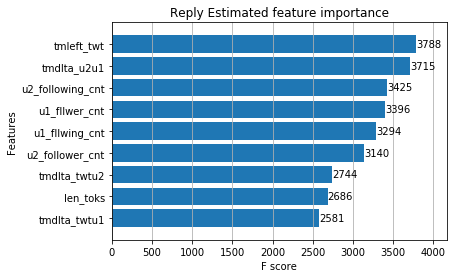

Reply


,0,1
5,tmleft_twt,3788
6,tmdlta_u2u1,3715
4,u2_following_cnt,3425
8,u1_fllwer_cnt,3396
11,u1_fllwing_cnt,3294
12,u2_follower_cnt,3140
2,tmdlta_twtu2,2744
17,len_toks,2686
21,tmdlta_twtu1,2581
15,tmleft_u2,1645


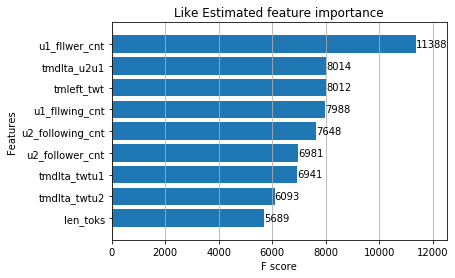

Like


,0,1
6,u1_fllwer_cnt,11388
11,tmdlta_u2u1,8014
24,tmleft_twt,8012
34,u1_fllwing_cnt,7988
7,u2_following_cnt,7648
14,u2_follower_cnt,6981
9,tmdlta_twtu1,6941
17,tmdlta_twtu2,6093
3,len_toks,5689
5,tmleft_u2,3412


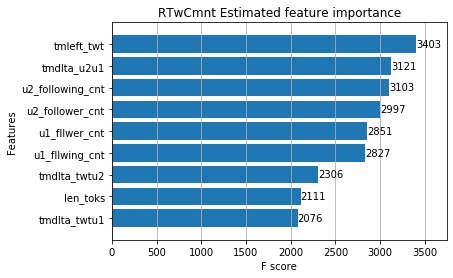

RTwCmnt


,0,1
11,tmleft_twt,3403
5,tmdlta_u2u1,3121
10,u2_following_cnt,3103
0,u2_follower_cnt,2997
4,u1_fllwer_cnt,2851
18,u1_fllwing_cnt,2827
7,tmdlta_twtu2,2306
19,len_toks,2111
14,tmdlta_twtu1,2076
9,tmleft_u2,1565


In [26]:
def show_feat_importance(tgt):
    bst=tgt2res[tgt]['bst']
    ax = xgb.plot_importance(bst, height=0.8, max_num_features=9)
    ax.grid(False, axis="y")
    ax.set_title(f'{tgt} Estimated feature importance')
    plt.show()
    feat2importance=bst.get_fscore()
    print(tgt)
    display(pd.DataFrame([feat2importance.keys(), 
                          feat2importance.values()]).T.sort_values(1, ascending=False))

for tgt in tgts:
    show_feat_importance(tgt)

In [27]:
for tgt in tgts:
    res=tgt2res[tgt]
    print(tgt)
    prdtr, prdvl = res['prdtr'], res['prdvl']
    ytr, yvl = res['ytr'], res['yvl']
    auc_tr=compute_prauc(prdtr, ytr)
    rce_tr=compute_rce(prdtr, ytr)
    auc_vl=compute_prauc(prdvl, yvl)
    rce_vl=compute_rce(prdvl, yvl)
    res['scrs'] = {
        'auc_tr':auc_tr,
        'rce_tr':rce_tr,
        'auc_vl':auc_vl,
        'rce_vl':rce_vl,
    }    
    print('tr prauc:', f'{auc_tr:.4f}','tr rce:', f'{rce_tr:.4f}', )
    print('vl prauc:', f'{auc_vl:.4f}','vl rce:', f'{rce_vl:.4f}', )

Retweet
tr prauc: 0.4677 tr rce: 22.3502
vl prauc: 0.3585 vl rce: 14.8282
Reply
tr prauc: 0.1620 tr rce: 16.0459
vl prauc: 0.0987 vl rce: 11.7939
Like
tr prauc: 0.8430 tr rce: 32.7466
vl prauc: 0.7524 vl rce: 20.7009
RTwCmnt
tr prauc: 0.0562 tr rce: 9.4349
vl prauc: 0.0205 vl rce: 4.7527


In [28]:
lsttr=[]
lstvl=[]
for tgt in ['Retweet','Reply','Like','RTwCmnt',]:
    res = tgt2res[tgt]
    if tgt not in tgt2res: continue
    lsttr+=[(f'PRAUC {tgt}',res['scrs']['auc_tr']),
          (f'RCE {tgt}',res['scrs']['rce_tr'])]
    lstvl+=[(f'PRAUC {tgt}',res['scrs']['auc_vl']),
          (f'RCE {tgt}',res['scrs']['rce_vl'])]

dfscrtr=pd.DataFrame(lsttr)
dfscrtr.columns=['metric','scr']
dfscrvl=pd.DataFrame(lstvl)
dfscrvl.columns=['metric','scr']
dfscr = pd.merge(dfscrtr, dfscrvl, on='metric', suffixes=('tr','vl'))
dfscr.T

,0,1,2,3,4,5,6,7
metric,PRAUC Retweet,RCE Retweet,PRAUC Reply,RCE Reply,PRAUC Like,RCE Like,PRAUC RTwCmnt,RCE RTwCmnt
scrtr,0.467746,22.3502,0.162003,16.0459,0.843049,32.7466,0.056208,9.43489
scrvl,0.358507,14.8282,0.0986543,11.7939,0.752424,20.7009,0.0204905,4.75267


# save results

In [29]:
pickle.dump(col2lang2mean, open(f'{p_out}/col2lang2mean.p', 'wb'))
pickle.dump(cols_feat, open(f"{p_out}/cols_feat.p", "wb"))
pickle.dump(tgt2res, open(f"{p_out}/tgt2res.p", "wb"))

In [30]:
pickle.dump(cols_feat, open(f"{p_out}/cols_feat.p", "wb"))
pickle.dump(tgt2res, open(f"{p_out}/tgt2res.p", "wb"))

# infer

In [37]:
%%time
dftst=pd.read_csv(
    f'{p_in}/val_{valtmstmp}.tsv',
    sep='\x01', header=None, names=cols_val, 
#     nrows=10
)


CPU times: user 1min 34s, sys: 8.68 s, total: 1min 43s
Wall time: 1min 43s


In [38]:
%%time
dftst = prpdf(dftst, istrn=False)

CPU times: user 6min 26s, sys: 1min 4s, total: 7min 31s
Wall time: 7min 30s


## mean encoding

In [39]:
for col,lang2mean in col2lang2mean.items():
    dftst[f'mean_lang_{col}']  = dftst.lang.map(lang2mean)
dftst.drop(columns='lang',inplace=True)


In [40]:
%%time
dtst = xgb.DMatrix(dftst[cols_feat], feature_names=cols_feat)
tgt2prdtst={}
for tgt in tgts:
    print(dtnow(), tgt)
    bst = tgt2res[tgt]['bst']
    prdtst = bst.predict(dtst, ntree_limit=bst.best_ntree_limit)
    tgt2prdtst[tgt] = prdtst

2020-04-03 01:08:00 Retweet
2020-04-03 01:08:33 Reply
2020-04-03 01:08:37 Like
2020-04-03 01:10:47 RTwCmnt
CPU times: user 45min 28s, sys: 25.7 s, total: 45min 53s
Wall time: 4min 9s


In [41]:
dfsub_ids = dftst[['twtid','u2id',]]

tgt2dfsub = {}
for tgt,prdtst in tgt2prdtst.items():
    dfsub = dfsub_ids.copy()
    dfsub['scr'] = prdtst
    tgt2dfsub[tgt]=dfsub

In [42]:
%%time
for i,tgt in enumerate(['Retweet','Reply','RTwCmnt','Like',]):
    dfsub = tgt2dfsub[tgt]
    print(dtnow(), tgt)
    dfsub.to_csv(f'{p_out}/{i}_{tgt}__{valtmstmp}__{PRFX}.csv',index=False,header=False)

2020-04-03 01:10:50 Retweet
2020-04-03 01:11:46 Reply
2020-04-03 01:12:42 RTwCmnt
2020-04-03 01:13:39 Like
CPU times: user 3min 32s, sys: 6.28 s, total: 3min 38s
Wall time: 3min 43s
